In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [19]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        policy = np.zeros(nA)
        best_a = np.argmax(Q[observation])
        for a in range(nA):
            policy[a] = 1 - epsilon + (epsilon/nA) if a == best_a else epsilon/nA
        return policy
    return policy_fn

In [26]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    nA = env.action_space.n
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(nA))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, nA)
    
    # Implement this!
    for episode in range(num_episodes):
        observation = env.reset()
        experiences = []
        while True:
            action = np.random.choice(np.arange(nA), p=policy(observation))
            experience = [observation, action]
            observation, reward, done, _ = env.step(action)
            experience.append(reward)
            experiences.append(tuple(experience))
            if done:
                break
        
        G = 0
        for experience in experiences:
            St, At = experience[:2]
            first_index = next((i for i,x in enumerate(experiences) if x[0]==St and x[1]==At))
            G = sum((x[2]*(discount_factor**i) for i,x in enumerate(experiences[first_index:])))
            returns_sum[(St, At)] += G
            returns_count[(St, At)] += 1.0
            Q[St][At] = (returns_sum[(St, At)]/returns_count[(St, At)])
            
    return Q, policy

In [27]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

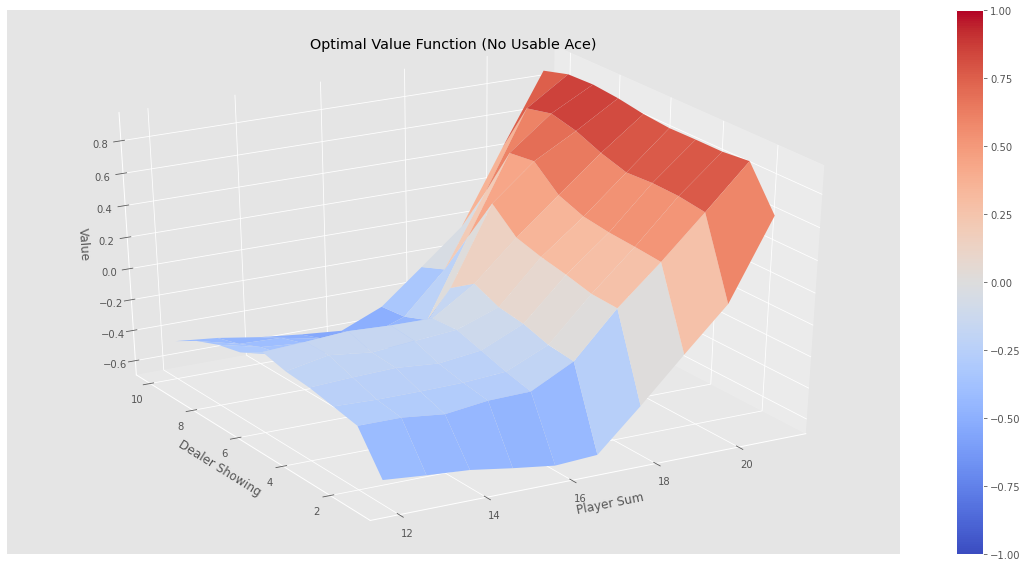

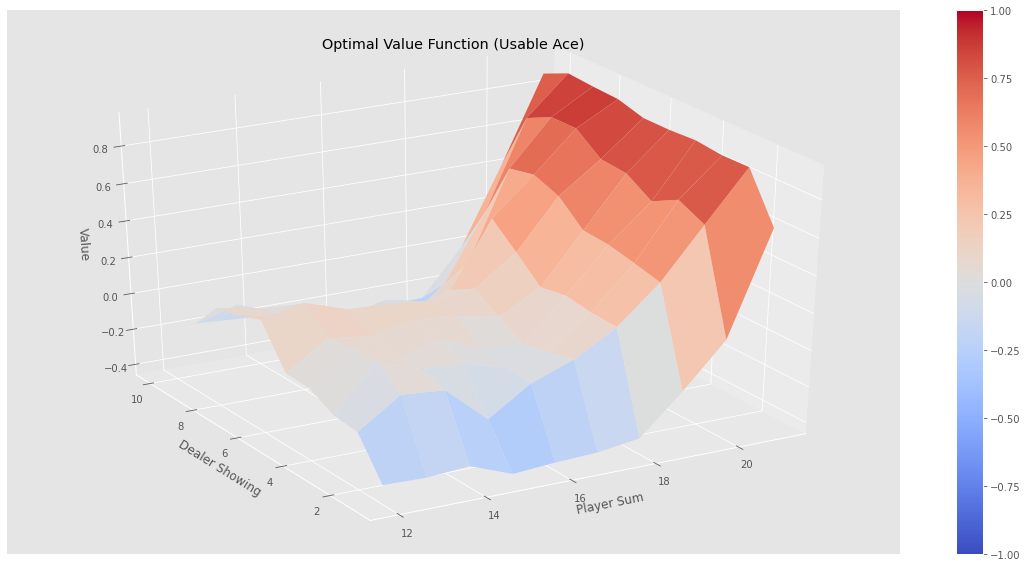

In [28]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")